In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from Bio import SeqIO
import os
import re

In [2]:
from deepcoil import DeepCoil
from deepcoil.utils import plot_preds

In [3]:
input_file = "/ebio/abt1_share/prediction_hendecads/data/new_prot_fam_data/final_dataset.fasta"

fasta_sequences = list(SeqIO.parse(open(input_file),'fasta'))
n_seq = len(fasta_sequences)

In [11]:
if os.path.exists('/ebio/abt1_share/prediction_hendecads/data/stretches.csv'):
    df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/data/stretches.csv')

else:
    df = pd.DataFrame(columns=['id', 'seq', 'stretch_ix', 'stretch_seq'])

    pattern = r'\[\[.*?\]\]'  # pattern to extract stretches

    for seq_ix, seq in enumerate(fasta_sequences):
        
        print(f"Processing sequence {seq_ix+1}/{n_seq}", end='\r')

        s = str(seq.seq)
        d = str(seq.description)

        stretches = eval(re.findall(pattern, d.split('|||')[-1])[0])

        for st_ix, st in enumerate(stretches):
            df = df.append({'id': seq.id, 'seq': s, 'stretch_ix': st, 'stretch_seq': s[st[0]:st[1]]}, ignore_index=True)

df.head()

,id,seq,stretch_ix,stretch_seq
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...


In [6]:
out_file = '/ebio/abt1_share/prediction_hendecads/tmp/stretches.fasta'

with open(out_file, 'w') as f:
    for i, row in df.iterrows():

        print(f"Writing sequence {i+1}/{len(df)}", end='\r')

        f.write(f">{row['id']}_{str(row['stretch_ix']).replace(' ', '')}\n{row['stretch_seq']}\n")

In [12]:
dc = DeepCoil(use_gpu=False)

N = 150

inp = {str(entry.id): str(entry.seq) for entry in SeqIO.parse(out_file, "fasta")}
trunc_inp = {k: v for k, v in list(inp.items())[:N]}

preds = dc.predict(trunc_inp)

averages = [np.mean(preds[key]['cc']) for key in preds.keys()]

temp_df = df.loc[:N-1, ]
temp_df['avg_cc'] = averages

/ebio/abt1_share/prediction_hendecads/conda/miniconda3/envs/deepcoil/lib/python3.8/site-packages/deepcoil/deepcoil.py:113: UserWarning: Non-standard residues detected in input data were corrected to X token.
  warnings.warn('Non-standard residues detected in input data were corrected to X token.', UserWarning)
/ebio/abt1_share/prediction_hendecads/conda/miniconda3/envs/deepcoil/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


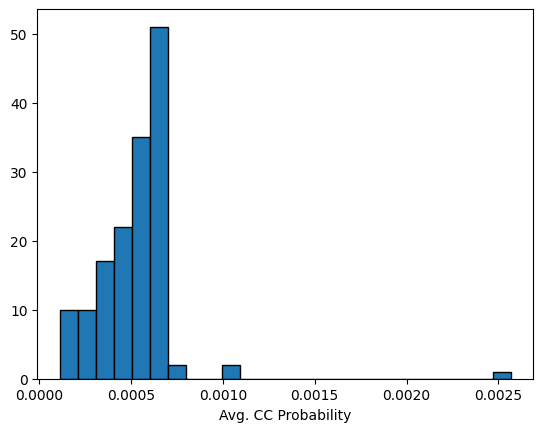

In [13]:
temp_df.avg_cc.hist(bins=25, edgecolor='black', grid=False)

plt.xlabel('Avg. CC Probability')
plt.show()